# Code Availability
This code is written in Python (3.6>) and publicly available. The aim is to provide a custom code to process, visualize and manipulate the SandBoxNL dataset. 

Support:
In the case of any issues or inquiries please contact either:

Manuel Huber (ESA, ESTEC, manuel.huber@esa.int, Author of the script),
Vineet Kumar (TU Delft, V.Kumar-1@tudelft.nl)
 


# Introduction: SandBoxNL Dataset - Sentinel 2
The annual database consists of spatially averaged multi-spectral bands of the Sentinel 2 mission and is provided per province and annually. The temporal extension of the data is starting from 2018, as from this year on the missions S2A and S2B were available. So far, 2018, 2019 and 2020 have been produced.  

The following code gives a brief example of how to access, manipulate and visualize the pickle Sentinel 2 dataset with Flevoland (2019) as an example. 

In general, the dataset is stored per province and resolution. Some of the spectral bands having 10m or 20m resolution. Because of this each province has two files namely: Porv_xxx_S2_10m and Prov_xxx_S2_20m

In [1]:
"""
 -*- coding: utf-8 -*-
Created on Tue Apr  6 16:05:00 2021
@author: Manuel Huber (ESA, ESTEC: manuel.huber@esa.int)
"""

import netCDF4 as nc4
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from netCDF4 import Dataset
#import pickle
import pickle5 as pickle
from datetime import datetime, date, time
import glob
import math    
import os
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely import wkt
import shapely
import calendar

In [2]:
# Reading the data.... 
# Example for one province in 2018

prov =  'Flevoland'
year = '2018'

# Selecting one province as example... 
# Also only the 10m pickle file has been selected as an example. By changing the name the other file can be loaded instead. 
# Changing this means also to adjust the column names later in the script. 

path = 'C:/Users/Manuel Huber/Documents/FInal Datasets SandboxNL/Pickle_{}/Prov_{}/'.format(year,prov)
infile = open('{}Prov_{}_S2_Res_10m.pickle'.format(path,prov),'rb')
S2_10 = pickle.load(infile)
parcelS2_10 = S2_10['Parcel_Information']
del S2_10['Parcel_Information']
    

# Selecting and loading PDOK shp files for geometry and crop description...
#fields = gpd.read_file('C:/Users/Manuel Huber/Documents/FInal Datasets SandboxNL/SandBoxNL/SandboxNL/April_2020/BRP_2019_proj/BRP_Proj_2019.shp') 
fields = gpd.read_file('C:/Users/Manuel Huber/Documents/FInal Datasets SandboxNL/SandBoxNL/SandboxNL/April_2020/BRP_2018_proj/BRP_2018_proj')

municipality_all = gpd.read_file('C:/Users/Manuel Huber/Documents/FInal Datasets SandboxNL/SandBoxNL/SandboxNL/gemme_2018_proj/gem_2018_proj.shp')

province_all = gpd.read_file('C:/Users/Manuel Huber/Documents/FInal Datasets SandboxNL/SandBoxNL/SandboxNL/Province_Netherlands_Proj/Province_Netherlands_Proj/Province_van_nederland_proj.shp')

# Select all municipalities within the loaded province (example)

In [3]:

selected_prov = province_all[province_all.PROV_NAAM == prov].iloc[0]

municipalities = []

for i in range(len(municipality_all)):
    point = shapely.wkt.loads(municipality_all.iloc[i].geometry.centroid.wkt)
    if selected_prov.geometry.contains(point):
        municipalities.append(municipality_all.iloc[i])
municipalities = pd.concat(municipalities, axis =1).T 
print('All municipalities within the loaded province: ', municipalities.GM_NAAM.values)

All municipalities within the loaded province:  ['Almere' 'Zeewolde' 'Noordoostpolder' 'Urk' 'Dronten' 'Lelystad']


# Find crop types from BRP parcel name list.
The Basisregestratie GewasPercelen (BRP, Base Crop Parcel Register) shape filescontains parcel name information in Dutch. To extract the information about theparticular parcel or crop type user needs to input/query the database in Dutch. Hence to assist crop type information, we have provided the following list detailsthe corresponding crop name in English  ("BRP_Parcel_Name_list_dutsch_english_2019") . 

User needs to input exact name of crop in Dutch language including the special characters (Example: Aardappelen, bestrijdingsmaatregel AM). These following list is created by using BRP 2019 data. Specifically Maize crop has a special character in the BRP-2019 shape files,(Ma�s, snij-). So, user should carefully input while calling 2019 maize cropdatabase. For 2017 and 2018 Maize crop can be called with actual Dutchword (Maïs) for it.

The following code should help to select the correct dutch crop names. Two functions are implemented to either find the corresponding names using either a english crop name or starting letter. In total 312 different crops are prese

In [4]:
# Loading the excel sheet, which contains the dutch and english description of the crop types
translate = pd.read_excel('C:/Users/Manuel Huber/Documents/FInal Datasets SandboxNL/BRP Translation/Translation_List_Dutch_English_Crop_Names_2019.xlsx')
translate.index = translate['Crop_Number'].astype(int)  # The crop number refers to the 'GWS_GEWASC' number of the BRP/Fields files
del translate['Crop_Number']

# Function to find all descriptive names (dutch and englisch) for a given crop name/type (given in englisch)
def find_crop_names_per_name(mystring):
    index = []
    for i in range(len(translate)):
        cell = translate['Crop name (English)'].iloc[i]
        if mystring in cell:
            index.append(i)
    return translate.iloc[index]

# Function to find crops with starting letter of the crop name/type (serach in english)
def find_crop_names_per_letter(myletter):
    index = []
    for i in range(len(translate)):
        cell = translate['Crop name (English)'].iloc[i]
        if myletter in cell[0]:
            index.append(i)
    return translate.iloc[index]

# Two examples on how to use the above functions:
example1 = find_crop_names_per_name("Potatoes") # Input must be in english. Sometimes 
                                                # Crops are given in plural or small/big captial starting letter
                                                # If this does not help please search manually in the trasnlation list
print('Output for search using an english name:','\n',example1)


# If it is not possible to find the crop using the full name try to search for the starting letter:
example2 = find_crop_names_per_letter("W") # Input must be in in engish and capital (sometimes large or small)
print('Output for search using a letter:','\n',example2)




Output for search using an english name: 
                                            Crop name (English)  \
Crop_Number                                                      
2014                                      Potatoes consumption   
2015             Potatoes seeds other than for starch potatoes   
2016                        Potatoes seeds for starch potatoes   
2017                                          Potatoes, starch   
2025         Potatoes, control measures for Aardappelmoehei...   

                                 Crop name (Dutch)  
Crop_Number                                         
2014                       Aardappelen, consumptie  
2015                         Aardappelen, poot NAK  
2016                         Aardappelen, poot TBM  
2017                          Aardappelen, zetmeel  
2025         Aardappelen, bestrijdingsmaatregel AM  
Output for search using a letter: 
                                         Crop name (English)  \
Crop_Number             

In [5]:
# Getting list of variables stored in the netCDF


# Keys for static data (Parcel)
keys_ID = list(parcelS2_10.index)

# Static data (Parcel)
keys_stat = list(parcelS2_10.columns)

# Keys for time variable data (Parcel x Time)
keys_data = list(S2_10 [keys_ID[0]].columns)


print('Variables per ID:' ,'\n', keys_data)
print('Static Information per ID:' ,'\n',keys_stat)


Variables per ID: 
 ['B2_mean', 'OID', 'B3_mean', 'B4_mean', 'B8_mean', 'B2_std', 'B3_std', 'B4_std', 'B8_std', 'Pix_count']
Static Information per ID: 
 ['Polygon_Centroid', 'lon', 'lat', 'polygon', 'gem', 'prov']


# Structuring the data
In this part addtional information about the individual fields is added to the static dataframe.

In [6]:


# Combine static information with field information to one dataframe
fields.index = fields.OBJECTID.astype(int)
fields_sel = fields[fields.index.isin(parcelS2_10.index)] # Select only field IDs which are represented in the loaded data


df_ID_all = pd.concat([parcelS2_10,fields_sel],axis=1) # Combine field information with static parcel information into one dataframe

print(df_ID_all.info(), df_ID_all.head())


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 16268 entries, 1526214 to 2300881
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Polygon_Centroid  16268 non-null  object  
 1   lon               16268 non-null  object  
 2   lat               16268 non-null  object  
 3   polygon           16268 non-null  geometry
 4   gem               16268 non-null  object  
 5   prov              16268 non-null  object  
 6   OBJECTID          16268 non-null  int64   
 7   CAT_GEWASC        16268 non-null  object  
 8   GWS_GEWASC        16268 non-null  object  
 9   GEOMETRIE_        16268 non-null  float64 
 10  GEOMETRIE1        16268 non-null  float64 
 11  GWS_GEWAS         16268 non-null  object  
 12  geometry          16268 non-null  geometry
dtypes: float64(2), geometry(2), int64(1), object(8)
memory usage: 1.7+ MB
None                                           Polygon_Centroid      lon      la

# Selecting ObjectIDs and field information depending on longitude and latitude

This is necessary for users, who have a list of longitudes and latitudes and want to select the fields according to those. This can be done using the fields polygons (provided by PDOK). The polygons are selected on the bases that the lon-lat combination (point) is within the outlined polygon. This means that the points must be in the boundary of the parcel in order to be identified. Again, it is to mention that the field locations change per year, which makes it important to always select the correct shapefile. Furthermore, it is important to have loaded the correct netCDF file to match the objectIDs.  

In the following example, points where selected in the Flevoland province.


Int64Index([1982499, 1560970, 1903813, 2103386, 2153593, 2029705, 1899505,
            1558368, 1903812, 2077497, 1716849, 2169741, 2087039, 1555069],
           dtype='int64', name='OBJECTID')


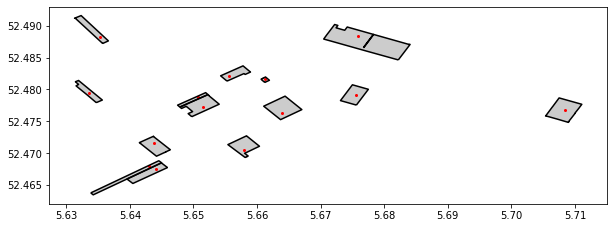

In [7]:
# List of points (this can be integrated by uploading a csv file - in case a lat-lon list exists already)
list_lon_lat = [
    [5.675902485185551,52.48838138537458],
    [5.663843273454594,52.47630669355332],
    [5.655646442705082,52.482083095990625],
    [5.70838940077393,52.476829476115576],
    [5.675602077775883,52.47918192078341],
    [5.651483654313969,52.47722155896118],
    [5.657878040605473,52.470477247257],
    [5.643801807695317,52.47157522890128],
    [5.661268352800297,52.48156037584885],
    [5.650754093461918,52.47884213099183],
    [5.635304569536137,52.48827685681074],
    [5.633502125078129,52.47949557056959],
    [5.642943500810551,52.467889039283634],
    [5.644059299760746,52.46754916228505]
    ]
# Create a geocoded points
df_points = [Point(list_lon_lat[i][0], list_lon_lat[i][1]) for i in range(len(list_lon_lat))]

# Function to extract the polygon for each field in the list
def get_id_per_lon_lat(list_lon_lat, fields):
    ls_points = []
    for i in range(len(list_lon_lat)):                   
        point = Point(list_lon_lat[i][0], list_lon_lat[i][1])
        ls_points.append(fields[fields.geometry.contains(point)])
    return pd.concat(ls_points)

lst_polygons = get_id_per_lon_lat(list_lon_lat, fields) # Apply function *fields = PDOK shapefile
selected_poly  = lst_polygons[lst_polygons.OBJECTID.isin(keys_ID)] # Check if the selected fields are in the netCDF dataset
# Plotting the selected parcels for the given points
fig,ax= plt.subplots(figsize=(10,4))
gpd.GeoDataFrame(selected_poly, geometry='geometry').plot(ax =ax, color='grey', alpha = 0.4,  missing_kwds={"edgecolor": "red"}) # Corresponding polygons
gpd.GeoDataFrame(selected_poly, geometry='geometry').boundary.plot(ax =ax, markersize=2, color='black')
gpd.GeoDataFrame(df_points, geometry=df_points).plot(ax =ax, markersize=4,color= 'red') # Points selected by user

selected_IDs = selected_poly.index # This gives a list OBJECTIDs corresponding to the selected fields.
print(selected_IDs)

#  Select fields within a municipality boundary
In order to work municipality wise the following code provide you an example to generate a list of OBJECTIDs which are associated to a given municipality within the loaded province. 
This example extracts all field IDs for Dronten. 

In [8]:
municipality = 'Dronten'  # Just an example municipality for the Flevoland province


def get_id_per_muncip(municipality, df_ID):
    select = municipality_all[municipality_all['GM_NAAM']== municipality]
    ls_points = []
    for i in range(len(df_ID)):                   
        point = Point(df_ID.lon.iloc[i], df_ID.lat.iloc[i])
        if select.iloc[0].geometry.contains(point)==True:
            ls_points.append(df_ID.iloc[i])
    return pd.concat(ls_points, axis = 1).T

df_per_municipality = get_id_per_muncip(municipality, df_ID_all) # List of parcel infomation for all fieds within the municipality
df_per_municipality.head() 


,Polygon_Centroid,lon,lat,polygon,gem,prov,OBJECTID,CAT_GEWASC,GWS_GEWASC,GEOMETRIE_,GEOMETRIE1,GWS_GEWAS,geometry
1526403,"{""type"":""Point"",""coordinates"":[5.6525767438520...",5.65258,52.4902,"POLYGON ((5.652039460647789 52.48852572106463,...",Dronten,Flevoland,1526403,Bouwland,2014,1088.92,74017,"Aardappelen, consumptie","POLYGON ((5.652039460647789 52.48852572106463,..."
1527017,"{""type"":""Point"",""coordinates"":[5.7003472766472...",5.70035,52.5058,"POLYGON ((5.700600026323468 52.5051040847348, ...",Dronten,Flevoland,1527017,Bouwland,258,509.038,9643.99,Luzerne,"POLYGON ((5.700600026323468 52.5051040847348, ..."
1531238,"{""type"":""Point"",""coordinates"":[5.7418221592619...",5.74182,52.5332,"POLYGON ((5.743653852645989 52.53211649353052,...",Dronten,Flevoland,1531238,Bouwland,233,941.78,52296.6,"Tarwe, winter-","POLYGON ((5.743653852645989 52.53211649353052,..."
1532220,"{""type"":""Point"",""coordinates"":[5.6507649857674...",5.65076,52.5584,"POLYGON ((5.653745336722294 52.55702319263321,...",Dronten,Flevoland,1532220,Bouwland,2025,1025.65,14973.7,"Aardappelen, bestrijdingsmaatregel AM","POLYGON ((5.653745336722294 52.55702319263321,..."
1532504,"{""type"":""Point"",""coordinates"":[5.6447186560758...",5.64472,52.5772,"POLYGON ((5.644237956547349 52.57494488652407,...",Dronten,Flevoland,1532504,Bouwland,2015,1346.23,103757,"Aardappelen, poot NAK","POLYGON ((5.644237956547349 52.57494488652407,..."


# Selecting processing IDs

In this section you can choose which IDs you want to use for the further analysis. So far there are three options:

1) All IDs within the province 
2) All IDs which were given manual from Lon/Lat combinations
3) All IDs within a given municipality

Please activate desired ID list in the following code lines:

In [9]:
# ------ IDs per province  ------#
df_data = S2_10
df_ID = df_ID_all

# ----- IDs per given Lon/Lats: ------#
#df_ID = df_ID_all[df_ID_all.index.isin(selected_IDs.values)]
#df_data = { your_key: S2_10[your_key] for your_key in df_ID.index }

# ----- IDs per given municipality:  ------#
#df_ID = df_ID_all[df_ID_all.index.isin(df_per_municipality.index)]
#df_data = { your_key: S2_10[your_key] for your_key in df_ID.index }

# Calculate Band Indexs such as NDVI

In [10]:
# Writing for all selected fields the NDVI in the dataframe, so it can be accessed together with the other spectral bands
for i in range(len(df_data)):
    s2_sel = df_data[df_ID.index[i]]
    df_data[df_ID.index[i]]['NDVI'] = (s2_sel['B8_mean']-s2_sel['B4_mean'])/(s2_sel['B8_mean']+s2_sel['B4_mean'])

# Plotting time series for an example field

Here the static information can be used to select specific parcels. For example, certain crop types, parcels without flags, specific lon and lat etc. 

The data is still in linear scale, hence needs to be scaled to dB with math.log10(y)*10. 

NOTE: Plotting the time series without further selection gives all backscatter values for ALL orbits. If one is interested in a single orbit or desc./asc. it is necessary to select the orbits of interest beforehand.

date
2018-02-07 10:42:11    0.478968
2018-02-27 10:40:21    0.112389
2018-03-02 10:50:21    0.102314
2018-03-09 10:40:21    0.112608
2018-03-14 10:40:19    0.113809
Name: NDVI, dtype: float64


Text(0.5, 1.0, 'Field: 1526214 - Aardappelen, poot NAK')

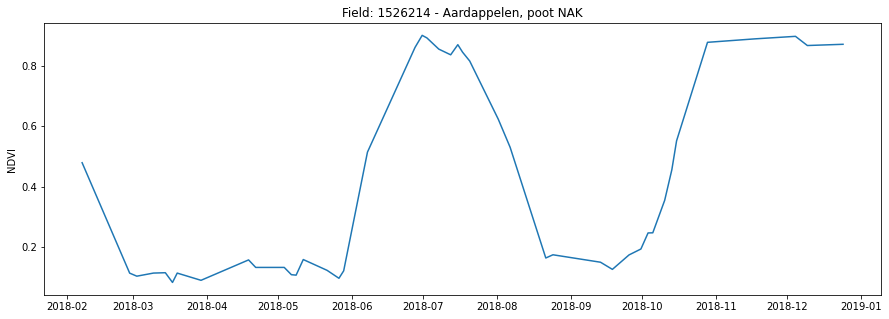

In [11]:
# First Plotting time series.... Comparing backscatter signal from all orbits to one orbit:
'''
Variables: 
 ['B2_mean', 'OID', 'B3_mean', 'B4_mean', 'B8_mean', 'B2_std', 'B3_std', 'B4_std', 'B8_std', 'Pix_count', 'NDVI']
These can be used as a vector or directly as a string.

'''

# Example selection of the first field in the dataframe
field = 0  

df_plot = df_data[df_ID.index[field]]['NDVI']                 

print(df_plot.head())


# Plotting mean NDVI for one field


fig, ax = plt.subplots(figsize=(15,5))

plt.plot(df_plot)
plt.ylabel('NDVI')
plt.title('Field: {} - {}'.format(df_ID.index[field],df_ID['GWS_GEWAS'].iloc[field]))




# Plotting time series for a certain crop type


In [12]:
# Plotting certain crop type variation

# 1) Get list of all crop types

list_crops = df_ID['GWS_GEWAS']
print(list_crops.head())

# 2) Get Object IDs for certain crop type using field data (PDOK)) 

crop_string = list_crops.iloc[0] #  Or you can insert a string manually 'Aardappelen, consumptie'
crop = df_ID[df_ID['GWS_GEWAS']==crop_string] 

print('Following example crop is:',crop_string, ' - Length Parcels: ', len(crop))

1526214      Aardappelen, poot NAK
1526403    Aardappelen, consumptie
1526456         Grasland, blijvend
1526457                Uien, zaai-
1526495             Tarwe, winter-
Name: GWS_GEWAS, dtype: object
Following example crop is: Aardappelen, poot NAK  - Length Parcels:  1637


In [13]:
# 2) Selecting data depending on the crop object IDs and orbit

# List of ObjectIDs
IDs = crop.index
df_crop = {your_key: S2_10[your_key] for your_key in IDs }


print(df_crop[IDs[0]].head())

                        B2_mean      OID      B3_mean      B4_mean  \
date                                                                 
2018-02-07 10:42:11  374.298206  1526214   501.500000   609.455157   
2018-02-27 10:40:21  899.968228  1526214  1103.958088  1381.378947   
2018-03-02 10:50:21  768.950289  1526214   950.576440  1223.452714   
2018-03-09 10:40:21  444.568366  1526214   534.534527   657.702535   
2018-03-14 10:40:19  489.435933  1526214   554.811877   696.460843   

                         B8_mean      B2_std      B3_std      B4_std  \
date                                                                   
2018-02-07 10:42:11  1729.959641  201.901310  188.882165  235.575477   
2018-02-27 10:40:21  1731.199532   23.711793   23.873174   21.841782   
2018-03-02 10:50:21  1502.340838   26.522217   29.940113   32.181432   
2018-03-09 10:40:21   824.624662   23.123957   28.249871   25.938015   
2018-03-14 10:40:19   875.346624   25.371592   27.907402   26.573421   

    

                mean       std
date                          
2018-01-01  0.096979  0.271525
2018-01-08  0.384223  0.281848
2018-01-11  0.308280  0.294360
2018-01-16  0.229555  0.149162
2018-01-18  0.368561  0.253878
...              ...       ...
2018-12-14  0.887284  0.081813
2018-12-17  0.538028  0.278432
2018-12-19  0.647273  0.268858
2018-12-22  0.528281  0.295074
2018-12-24  0.593885  0.284819

[134 rows x 2 columns]


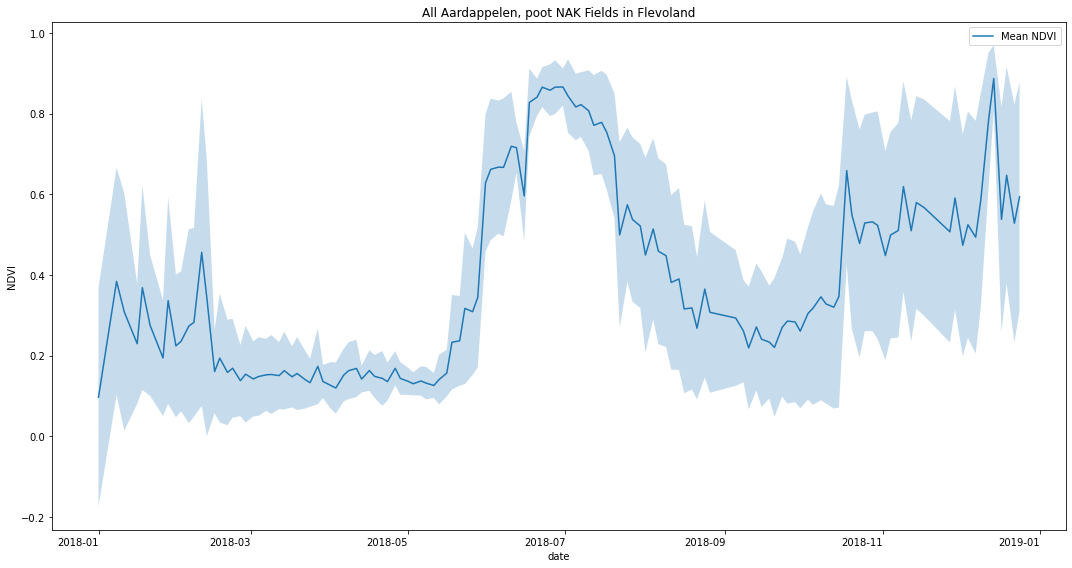

In [14]:
# 3) Plotting mean and variation for crop in province (Considering one Orbit)

# Function to calculate mean and std per field in a object ID selection
def get_std_mean_for_var(data, IDs, var):
    data_out = []
    for i in range(len(data)):   
        data_out.append(data[IDs[i]]['NDVI'].resample('10D').mean().dropna()) # To get rid of the nan values in case of multiple slices
    data_out = pd.concat(data_out, axis=1)
    mean_x = data_out.T.mean()
    std_x = data_out.T.std()
    df = pd.DataFrame()
    df['mean'] = mean_x 
    df['std'] = std_x 
    print(df)
    return [df['mean'], df['std']]

var_plot = 'NDVI'
var_crop = get_std_mean_for_var(df_crop, IDs,var_plot)


fig,ax= plt.subplots(figsize=(15,8))

var = var_crop
ax = var[0].plot(label = 'Mean {}'.format(var_plot))
ax.fill_between(var[0].index,  var[0] -  var[1],  var[0] +  var[1],
                alpha=.25)
ax.tick_params(axis='x', labelrotation=0 )
ax.set_ylabel("NDVI")
plt.legend()

plt.title('All {} Fields in {}'.format(crop.GWS_GEWAS.iloc[0],prov))
plt.tight_layout()

# Plotting spatially

In the fields (shapefile) the geometries are available to plot the field outlines. Filling these fields with colormaps depending on certain variables gives a good illustration of the spatial value distribution for a certain time step. 

Considering the cloud cover it is difficult to get a full-coverage of all fields for a specific date. Taking a mulit-timestep average can help reducing this, with the consequence of averaging out small scale changes. 

In this example Flevoland will be plotted:

1) Using a specific timestep
2) Using a monthly average


In [36]:
# 1) Using a specific timestep

# Get all unique dates: 
dates = []
for i in range(len(S2_10)):
    dates.append(S2_10[df_ID.index[i]].index.date)


dates_uni = np.unique(np.concatenate(dates))


# Concat all field for a specif field

ndvi_date_plot = []
id_ndvi = []
for i in range(len(S2_10)):
    if not S2_10[df_ID.index[i]][S2_10[df_ID.index[i]].index.date == dates_uni[10]].empty:
        id_ndvi.append(df_ID.index[i])
        ndvi_date_plot.append(S2_10[df_ID.index[i]][S2_10[df_ID.index[i]].index.date == dates_uni[10]])
ndvi_date_plot = pd.concat(ndvi_date_plot)
ndvi_date_plot.index = id_ndvi
print(ndvi_date_plot.head())




             B2_mean      OID      B3_mean      B4_mean      B8_mean  \
1526214   899.968228  1526214  1103.958088  1381.378947  1731.199532   
1526403   858.729978  1526403  1066.783745  1366.017707  1801.113427   
1526457  1094.599736  1526457  1294.630555  1599.281195  2091.753954   
1526495  1223.284021  1526495  1508.874620  1748.246672  2889.379264   
1526504  1029.804965  1526504  1307.097905  1639.472474  2047.781923   
...              ...      ...          ...          ...          ...   
2300602  1263.063280  2300602  1514.552141  1807.488071  2095.631471   
2300657   829.416255  2300657  1019.303333  1214.404321  1639.257807   
2300750  1697.708319  2300750  2156.739915  2687.314633  3255.837055   
2300816   912.561798  2300816  1238.078652  1248.415730  3780.359551   
2300840  1823.276025  2300840  2263.159793  2857.784308  3499.995607   

             B2_std      B3_std      B4_std      B8_std  Pix_count      NDVI  
1526214   23.711793   23.873174   21.841782  105.452706 

Text(0.5, 1.0, '2018-02-27')

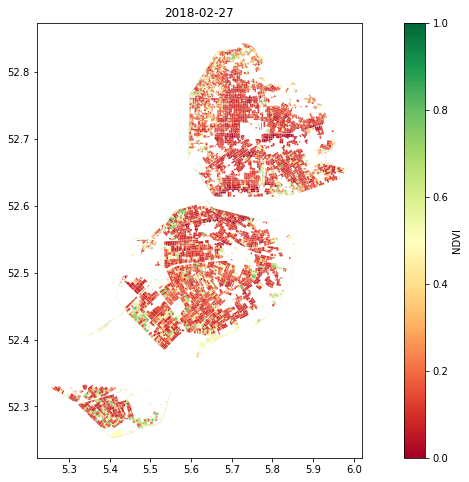

In [119]:
fig,ax= plt.subplots(figsize=(15,8))
# First using the parcel infromation dataframe to create a dataframe for the selected fields
geo_plot = gpd.GeoDataFrame(df_ID[df_ID.index.isin(ndvi_date_plot.index)], geometry='geometry')
# Adding the information to the dataframe, which wants to be plotted
geo_plot['NDVI'] = ndvi_date_plot['NDVI']
#Plotting NDVI spaitally
gpd.GeoDataFrame(geo_plot, geometry='geometry').plot(ax = ax,column = 'NDVI', cmap ='RdYlGn', legend=True, vmin =0, vmax =1,legend_kwds={'label': 'NDVI', 'orientation': "vertical"})
ax.set_title(str(dates_uni[10]))

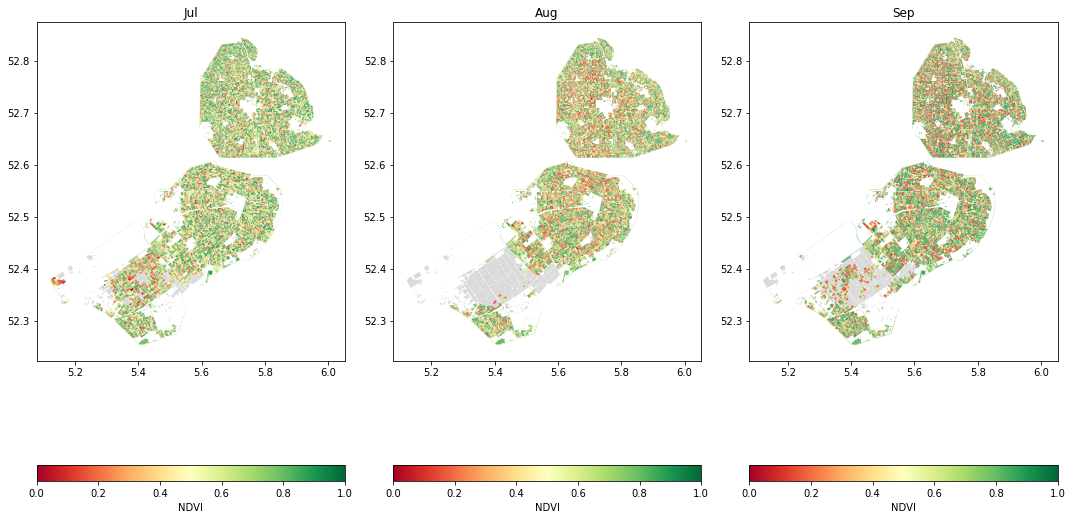

In [114]:
# 2) Using monthly averages to plot...

months = [calendar.month_abbr[i] for i in range(1,13)]

# Get all unique dates: 
s2_monthly = []
for i in range(len(S2_10)):
    s2_monthly.append(S2_10[df_ID.index[i]].resample('M').mean().NDVI)
    
s2_monthly = pd.concat(s2_monthly, axis=1).T
s2_monthly.index = df_ID.index 

monthly_dates = S2_10[df_ID.index[1]].resample('M').mean().index
s2_monthly_plot = s2_monthly.T

# Getting all fields within the Flevoland province, also those fields which are not captured by the Sentinel 2 database
selected_prov = province_all[province_all.PROV_NAAM == prov].iloc[0]
fields_all_prov = []
for i in range(len(fields)):
    point = shapely.wkt.loads(fields.geometry.iloc[i].centroid.wkt)
    if selected_prov.geometry.contains(point):
        fields_all_prov.append(fields.iloc[i])
fields_all_prov =  pd.concat(fields_all_prov, axis =1).T


# First using the parcel infromation dataframe to create a dataframe for the selected fields
geo_plot = gpd.GeoDataFrame(df_ID, geometry='geometry')
fig,ax = plt.subplots(1,3,figsize=(15,10))

for i in range(3):
    # Plotting the background fields ... 
    gpd.GeoDataFrame(fields_all_prov, geometry='geometry').plot(ax = ax[i], color = 'grey', alpha =0.3)
    geo_plot['NDVI'] = s2_monthly_plot.iloc[i+6]        
    gpd.GeoDataFrame(geo_plot, geometry='geometry').plot(ax = ax[i],column = 'NDVI', cmap ='RdYlGn', legend=True, vmin =0, vmax =1,legend_kwds={'label': 'NDVI', 'orientation': "horizontal"})
    ax[i].set_title(str(months[i+6]))  
    plt.tight_layout()